In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import load_data as load
from models.model import Model
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
from models.AELSTM import *
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')

# Encoder-Decoder

In [3]:
class AEModel(Model):
    def __init__(self, encoder, cell, decoder, 
                 latent_size, activation, 
                 batchsize, seqlen):
        
        self.latent_size = latent_size
        self.encoder = lambda inputs: encoder(inputs, latent_size=latent_size)
        self.cell_fw = cell(num_units=latent_size, activation=activation)
        self.cell_bw = cell(num_units=latent_size, activation=activation)
        self.decoder = decoder
        self.batchsize = batchsize
        self.seqlen = seqlen
        self.stacked_shape = (batchsize*seqlen, 60, 80, 3)
        self.sequence_shape = (batchsize, seqlen, 60, 80, 3)
        
    def build(self, inputs, reuse=False):
        with tf.variable_scope('encoder', reuse=reuse):
            inputs = self.stack(inputs)

            encoded = self.encoder(inputs)
            encoded = self.unstack(encoded)
            
        with tf.variable_scope('lstm', reuse=reuse):
            # initialize hidden state with ones instead of zeros to ensure pass-through at start
            initial_state = tfrnn.LSTMStateTuple(
                tf.ones((self.batchsize, self.latent_size)),
                tf.zeros((self.batchsize, self.latent_size))
            )

            junks, seeds = tf.nn.dynamic_rnn(
                self.cell_fw, encoded,
                initial_state=initial_state,
                sequence_length=[self.seqlen]*self.batchsize,
                dtype=tf.float32, swap_memory=True,
            )
            

            def rnn_step(next_tuple, next_elem):
                input, state = next_tuple
                output, next_state = self.cell_fw(input, state)                
                return (output, next_state)
            
            state = seeds
            next_input = state[1]
            elems = np.arange(self.seqlen)
            
            outputs, states = tf.scan(rnn_step, elems, (next_input, state), swap_memory=True)
            transitioned = tf.transpose(outputs, (1, 0, 2))

            transitioned_ = self.stack(transitioned)

        with tf.variable_scope('encoder', reuse=True):
            decoded = self.decoder(transitioned_)
            decoded = self.unstack(decoded)

        return encoded, transitioned, decoded

In [4]:
training_epochs = 20
batchsize = 8
sequence_length = 64

model = AEModel(
    encoder, PTLSTMCell, tied_decoder, 
    latent_size=2048, activation=tf.nn.tanh, #lambda x: 1.1 * tf.nn.tanh(x),
    batchsize=batchsize, seqlen=sequence_length
)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs(
    'training', batchsize, training_epochs, 
    seqlen=sequence_length
)

encoded, transitioned, decoded = model.build(training_inputs)
frame_loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))
training_targets_diff = training_targets[1:] - training_targets[:-1]

decoded_diff = decoded[1:] - decoded[:-1]
transition_loss = tf.reduce_mean(tf.pow(decoded_diff, training_targets_diff, 2))

loss = frame_loss + transition_loss

optimizer = tf.train.AdamOptimizer(learning_rate=.000001)
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs(
    'validation', batchsize, 1, 
    seqlen=sequence_length
)

encoded_validation, transitioned_validation, decoded_validation = model.build(validation_inputs, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    transitions = []
    validation_predictions = []
    validation_transitions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [train_step, loss, encoded, transitioned, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                if step >= 250:
                    print(step, loss_value, np.mean(decoder_losses[-250:]))
                else:
                    print(step, loss_value)
                encodings.append(enc)
                transitions.append(trans)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, trans, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, transitioned_validation, 
                 decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_transitions.append(trans)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm-tied-forback')
    

0 17465.5
250 9121.48 14142.0
500 5534.11 7580.39
750 5647.38 5462.82
1000 3909.95 4758.19
1250 4740.98 4496.0
1500 3018.56 4180.15
1750 4063.21 3898.79
2000 4121.68 3790.4
2250 3141.42 3551.77
2500 3136.42 3431.16
2750 3320.2 3366.53
3000 2576.48 3226.38
3250 2745.23 3160.8
3500 3361.67 3090.07
3750 2569.64 3007.03
4000 3297.81 2968.24
4250 2782.3 2877.68
4500 2742.8 2894.68
4750 2944.04 2783.9
5000 2742.11 2756.82
5250 2316.02 2754.31
5500 2160.59 2691.56
5750 2519.92 2643.9
6000 2397.26 2645.27
6250 2195.92 2623.44
6500 2220.15 2571.67
6750 2800.75 2518.28
7000 2876.1 2535.53
7250 3060.58 2508.86
7500 2669.18 2504.71
7750 2735.53 2424.64
8000 2390.54 2423.29
8250 2549.41 2393.58
8500 2742.56 2398.87
8750 2244.68 2388.48
9000 2075.55 2322.35
9250 2798.46 2402.02
9500 1627.16 2351.25
9750 2180.69 2336.89
10000 1760.16 2317.84
10250 2400.88 2251.33
10500 1850.47 2270.34
10750 2404.71 2232.22
11000 2152.49 2271.98
11250 2590.83 2204.22
11500 2250.31 2218.76
11750 1949.43 2221.33
12000 2

[1000, 6000]

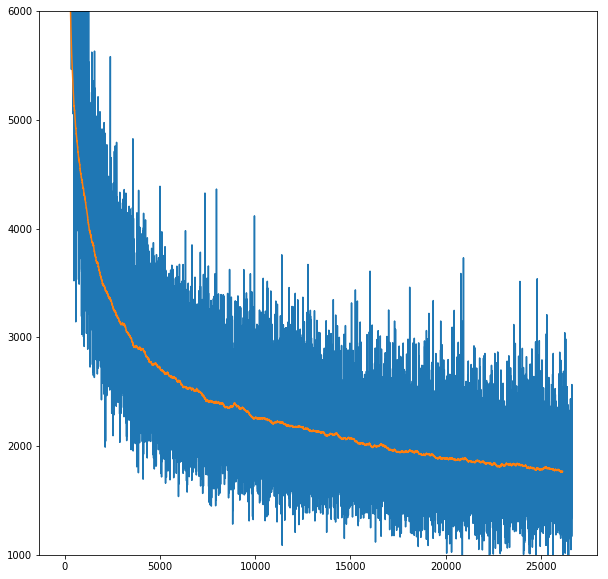

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
def rolling_mean(l, w=500):
    c = np.cumsum(l)
    c[w:] = c[w:] - c[:-w]
    return c[w-1:] / w
    

axes.plot(decoder_losses)
axes.plot(rolling_mean(decoder_losses))
plt.setp(axes, ylim=[1000, 6000])

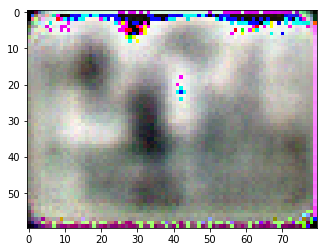

In [15]:
vid = -4
plt.imshow(predictions[vid][0][0]/255)

In [16]:
from render import render_movie

frame_array = render_movie(predictions[vid][0], 'test_squash_pred.mp4', 5)
frame_array = render_movie(recovery[vid][0], 'test_squash_recov.mp4', 5)

[MoviePy] >>>> Building video test_squash_pred.mp4
[MoviePy] Writing video test_squash_pred.mp4


100%|██████████| 17/17 [00:00<00:00, 1000.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_squash_pred.mp4 

[MoviePy] >>>> Building video test_squash_recov.mp4
[MoviePy] Writing video test_squash_recov.mp4



100%|██████████| 17/17 [00:00<00:00, 995.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_squash_recov.mp4 



# AE (No LSTM)

In [3]:
# check no-lstm AE

training_epochs = 25
batchsize = 8
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, decoded = model.build_encoder_decoder(training_inputs, reuse=False)    # discard decoder here
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

optimizer = tf.train.AdamOptimizer(learning_rate=.00001)
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, decoded_validation = model.build_encoder_decoder(validation_inputs, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    validation_predictions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, pred, input_recover = sesh.run(
                [train_step, loss, encoded, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'AE')

# LSTM-AE

In [ ]:
training_epochs = 25
batchsize = 8
sequence_length = 64

model = Model(encoder, lstm_cell, tied_decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, transitioned, decoded = model.build(training_inputs)
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

optimizer = tf.train.AdamOptimizer(learning_rate=.00001)
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, decoded_validation = model.build(validation_inputs, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [ ]:
np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]) / 1000000

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    transitions = []
    validation_predictions = []
    validation_transitions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [train_step, loss, encoded, transitioned, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                transitions.append(trans)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, enc, trans, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, transitioned_validation, 
                 decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_transitions.append(trans)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm-tied-relu')
    

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
def rolling_mean(l, w=500):
    c = np.cumsum(l)
    c[w:] = c[w:] - c[:-w]
    return c[w-1:] / w
    

axes.plot(decoder_losses)
axes.plot(rolling_mean(decoder_losses))
plt.setp(axes, ylim=[0, 2000])

In [ ]:
from render import render_movie

frame_array = render_movie(recovery[vid][0], 'test_ae_recov2.mp4', 5)